In [1]:
"""
CELL 1: IMPORT THƯ VIỆN & CẤU HÌNH
Mục đích: Nạp các thư viện cần thiết cho xử lý dữ liệu, vẽ đồ thị và các kiểm định thống kê chuỗi thời gian.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

# Thư viện thống kê & Time Series
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("tab10")
pd.set_option('display.max_columns', None)

print("✓ Đã nạp thư viện thành công.")

✓ Đã nạp thư viện thành công.


In [2]:
"""
CELL 2: TẢI & CHUẨN BỊ DỮ LIỆU (DATA LOADING)
Mục đích: Đọc dữ liệu từ file Zip theo đường dẫn của bạn và chọn trạm Aotizhongxin làm mẫu phân tích.
"""

# ĐƯỜNG DẪN FILE (Đường dẫn tuyệt đối trên máy bạn)
zip_path = r'E:\btl\air_quality_timeseries_7\data\raw\PRSA2017_Data_20130301-20170228.zip'

def load_data(zip_file, station_name='Aotizhongxin'):
    if not os.path.exists(zip_file):
        print(f"❌ Lỗi: Không tìm thấy file tại {zip_file}")
        return None
        
    with zipfile.ZipFile(zip_file, 'r') as z:
        # Tìm file csv chứa tên trạm
        file_list = z.namelist()
        target_file = next((f for f in file_list if station_name in f), None)
        
        if target_file:
            with z.open(target_file) as f:
                df = pd.read_csv(f)
                # Tạo cột datetime và set index
                df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
                df.set_index('datetime', inplace=True)
                df.sort_index(inplace=True)
                return df
        else:
            print(f"❌ Không tìm thấy dữ liệu cho trạm {station_name}")
            return None

# Tải dữ liệu
df = load_data(zip_path)

if df is not None:
    print(f"✓ Đã tải dữ liệu trạm Aotizhongxin. Kích thước: {df.shape}")
    print(f"✓ Giai đoạn: {df.index.min()} đến {df.index.max()}")

✓ Đã tải dữ liệu trạm Aotizhongxin. Kích thước: (35064, 18)
✓ Giai đoạn: 2013-03-01 00:00:00 đến 2017-02-28 23:00:00


In [16]:
"""
CELL 3: [Q1] KIỂM TRA TÍNH TOÀN VẸN VÀ LIÊN TỤC (CONTINUITY)
Mục đích: Xác định xem dữ liệu có bị ngắt quãng (missing timestamps) hay không.
"""
# Tạo khung thời gian lý tưởng (Full range)
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing_timestamps = full_range.difference(df.index)

print("--- 1. KIỂM TRA THỜI GIAN ---")
print(f"• Tổng số giờ lý thuyết: {len(full_range)}")
print(f"• Tổng số giờ thực tế: {len(df)}")
print(f"• Số giờ bị thiếu (Time Gaps): {len(missing_timestamps)}")

if len(missing_timestamps) == 0:
    print("=> KẾT LUẬN: Tần suất theo giờ là liên tục (Continuous).")
else:
    print("=> KẾT LUẬN: Dữ liệu bị đứt quãng. Cần Reindex để lấp đầy khoảng trống trước khi chạy model.")
    # Code xử lý nhanh (nếu cần): df = df.reindex(full_range)

--- 1. KIỂM TRA THỜI GIAN ---
• Tổng số giờ lý thuyết: 35064
• Tổng số giờ thực tế: 35064
• Số giờ bị thiếu (Time Gaps): 0
=> KẾT LUẬN: Tần suất theo giờ là liên tục (Continuous).


--- 2. TỶ LỆ THIẾU THEO BIẾN (%) ---
CO       5.065024
O3       4.902464
NO2      2.917522
SO2      2.666553
PM2.5    2.638033
PM10     2.047684
wd       0.231006
TEMP     0.057039
PRES     0.057039
DEWP     0.057039
RAIN     0.057039
WSPM     0.039927
dtype: float64


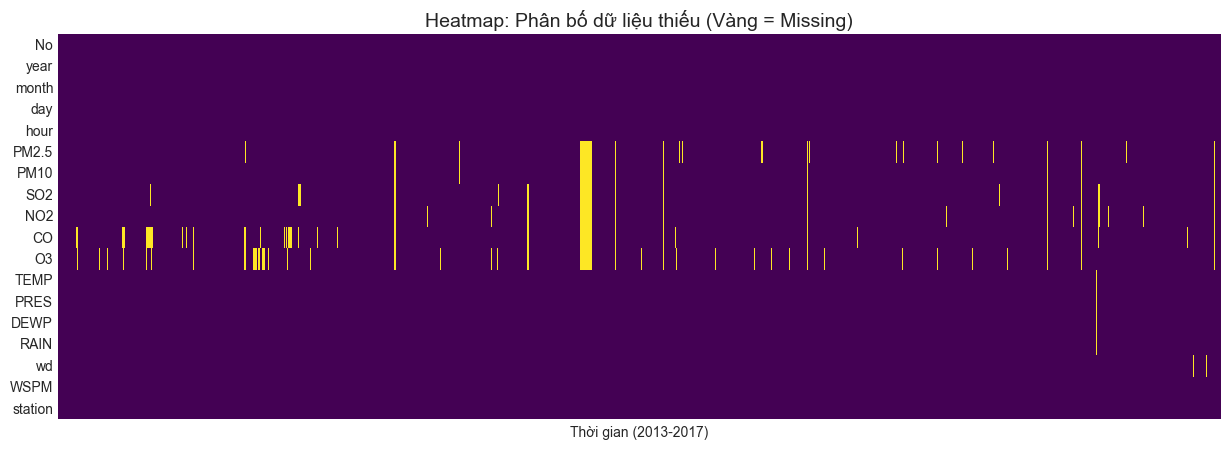


📌 GIẢI THÍCH: Thiếu biến nào đáng lo nhất cho dự báo PM2.5?
------------------------------------------------------------
Câu trả lời: Biến PM2.5 (Target variable).
Lý do:
1. Mất Target: Không có nhãn để tính lỗi (Loss) khi huấn luyện.
2. Gãy chuỗi Lag (Autoregression): Mô hình Time Series dựa vào giá trị quá khứ (Lag-1, Lag-24). 
   Nếu PM2.5 tại thời điểm t bị thiếu, thì tại t+1, t+24... các biến Lag sẽ trở thành NaN, 
   làm mất khả năng dự báo của cả một chuỗi dây chuyền sau đó.

Đã xử lý xong dữ liệu thiếu.


In [10]:
"""
CELL 4: [Q1] PHÂN TÍCH DỮ LIỆU THIẾU (MISSING VALUES)
Mục đích: Tính tỷ lệ thiếu, vẽ Heatmap và giải thích biến quan trọng nhất.
"""
# 1. Tỷ lệ thiếu
print("--- 2. TỶ LỆ THIẾU THEO BIẾN (%) ---")
missing_stats = df.isnull().mean() * 100
print(missing_stats[missing_stats > 0].sort_values(ascending=False))

# 2. Vẽ Heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(df.isnull().T, cbar=False, cmap='viridis', xticklabels=False)
plt.title('Heatmap: Phân bố dữ liệu thiếu (Vàng = Missing)', fontsize=14)
plt.xlabel('Thời gian (2013-2017)')
plt.show()

print("""
📌 GIẢI THÍCH: Thiếu biến nào đáng lo nhất cho dự báo PM2.5?
------------------------------------------------------------
Câu trả lời: Biến PM2.5 (Target variable).
Lý do:
1. Mất Target: Không có nhãn để tính lỗi (Loss) khi huấn luyện.
2. Gãy chuỗi Lag (Autoregression): Mô hình Time Series dựa vào giá trị quá khứ (Lag-1, Lag-24). 
   Nếu PM2.5 tại thời điểm t bị thiếu, thì tại t+1, t+24... các biến Lag sẽ trở thành NaN, 
   làm mất khả năng dự báo của cả một chuỗi dây chuyền sau đó.
""")
# Thêm đoạn này sau Cell 4
df['PM2.5'] = df['PM2.5'].interpolate(method='linear') # Hoặc dùng df.ffill()
print("Đã xử lý xong dữ liệu thiếu.")

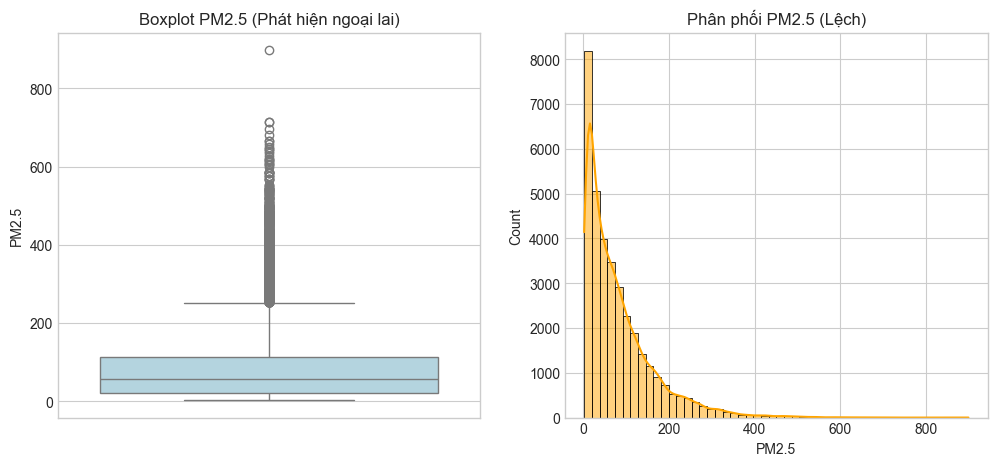

In [17]:
"""
CELL 5: [Q1] PHÁT HIỆN NGOẠI LAI & PHÂN PHỐI (OUTLIERS)
Mục đích: Dùng Boxplot để quan sát phân phối và các điểm dị biệt.
"""
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['PM2.5'].dropna(), color='lightblue')
plt.title('Boxplot PM2.5 (Phát hiện ngoại lai)')

plt.subplot(1, 2, 2)
sns.histplot(df['PM2.5'].dropna(), bins=50, kde=True, color='orange')
plt.title('Phân phối PM2.5 (Lệch)')
plt.show()

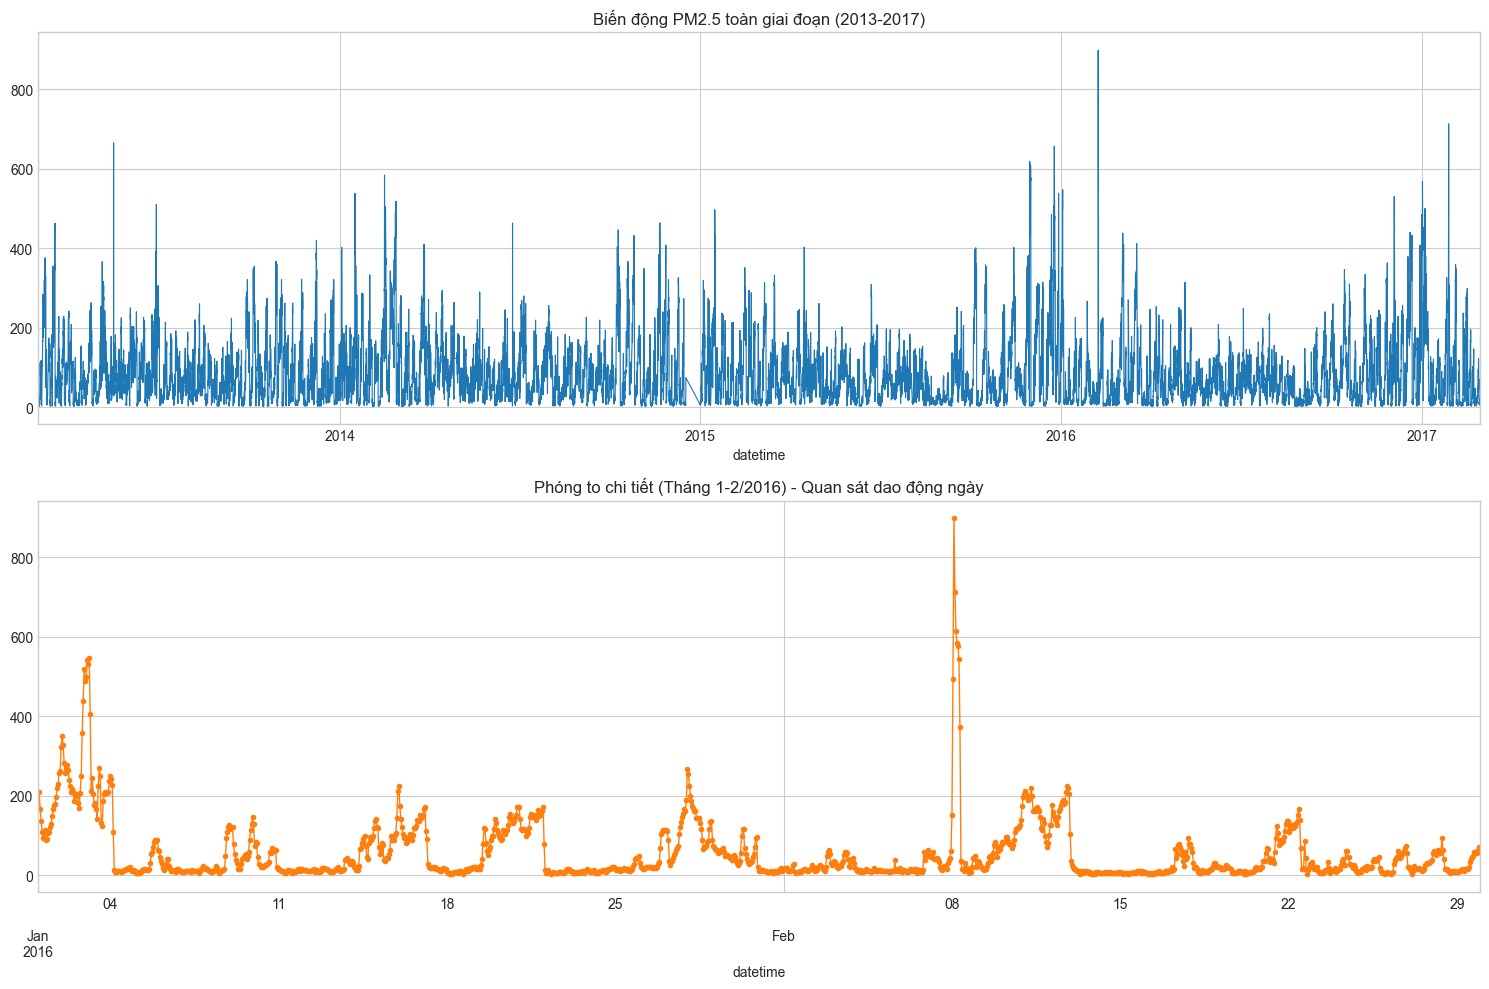

In [12]:
"""
CELL 6: [Q1] BIỂU ĐỒ CHUỖI THỜI GIAN (TIME SERIES PLOT)
Mục đích: Vẽ toàn cảnh và phóng to 2 tháng để nhìn rõ chu kỳ.
"""
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Toàn cảnh
df['PM2.5'].plot(ax=ax[0], color='#1f77b4', lw=0.8)
ax[0].set_title('Biến động PM2.5 toàn giai đoạn (2013-2017)')

# Phóng to 2 tháng (Tháng 1-2 năm 2016)
df['PM2.5'].loc['2016-01-01':'2016-02-29'].plot(ax=ax[1], color='#ff7f0e', marker='.', lw=1)
ax[1].set_title('Phóng to chi tiết (Tháng 1-2/2016) - Quan sát dao động ngày')

plt.tight_layout()
plt.show()

In [13]:
"""
CELL 7: [Q1] TỰ TƯƠNG QUAN & TÍNH DỪNG (AUTOCORR & STATIONARITY)
Mục đích: Kiểm tra chu kỳ ngày/tuần và kiểm định ADF.
"""
clean_series = df['PM2.5'].dropna()

# 1. Tự tương quan
corr_24 = clean_series.autocorr(lag=24)
corr_168 = clean_series.autocorr(lag=168)
print(f"--- TỰ TƯƠNG QUAN ---")
print(f"• Correlation (Lag 24h - Ngày): {corr_24:.4f} (Rất cao -> Chu kỳ ngày rõ rệt)")
print(f"• Correlation (Lag 168h - Tuần): {corr_168:.4f}")

# 2. Kiểm định ADF
print(f"\n--- KIỂM ĐỊNH DICKEY-FULLER (ADF) ---")
adf_res = adfuller(clean_series)
print(f"• ADF Statistic: {adf_res[0]:.4f}")
print(f"• p-value: {adf_res[1]:.4f}")

if adf_res[1] < 0.05:
    print("=> Kết luận: Chuỗi có tính dừng (Stationary) về mặt thống kê.")
else:
    print("=> Kết luận: Chuỗi KHÔNG dừng (Non-Stationary). Cần sai phân d=1.")

--- TỰ TƯƠNG QUAN ---
• Correlation (Lag 24h - Ngày): 0.4016 (Rất cao -> Chu kỳ ngày rõ rệt)
• Correlation (Lag 168h - Tuần): 0.0168

--- KIỂM ĐỊNH DICKEY-FULLER (ADF) ---
• ADF Statistic: -19.1170
• p-value: 0.0000
=> Kết luận: Chuỗi có tính dừng (Stationary) về mặt thống kê.


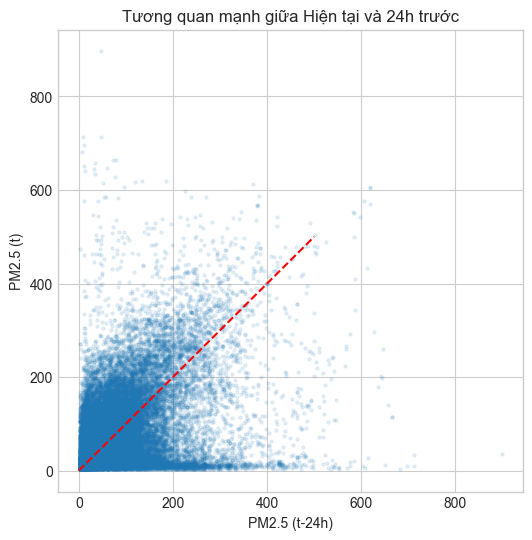

➤ Giải thích: Lag 24h quan trọng vì các hoạt động của con người và chu kỳ thời tiết (nhiệt độ, gió) lặp lại theo nhịp sinh học 24 giờ.

➤ Giải thích Split: Phải chia dữ liệu theo thời gian (Train < Cutoff < Test).
   Lý do: Để tránh Data Leakage (Rò rỉ dữ liệu). Nếu chia ngẫu nhiên, mô hình sẽ 'nhìn thấy' dữ liệu tương lai để dự đoán quá khứ, dẫn đến kết quả sai lệch khi triển khai thực tế.

➤ So sánh Metrics (Ví dụ minh họa):
   Thực tế: [ 10  20  15 100] | Dự báo: [12 18 14 50]
   RMSE: 25.04 | MAE: 13.75
   Kết luận: RMSE cao hơn nhiều (gần gấp đôi MAE) vì nó 'phạt nặng' sai số lớn tại điểm đột biến (100 vs 50).


In [14]:
"""
CELL 8: [Q2] MINH HỌA BASELINE HỒI QUY (MARKDOWN & CODE)
Mục đích: Giải thích trực quan về Lag 24, Cutoff và RMSE vs MAE.
"""

# --- PHẦN 1: TẠI SAO LAG 24 QUAN TRỌNG? ---
# Vẽ Scatter plot t vs t-24
plt.figure(figsize=(6, 6))
plt.scatter(df['PM2.5'].shift(24), df['PM2.5'], alpha=0.1, s=5)
plt.plot([0, 500], [0, 500], 'r--')
plt.xlabel('PM2.5 (t-24h)'); plt.ylabel('PM2.5 (t)')
plt.title('Tương quan mạnh giữa Hiện tại và 24h trước')
plt.show()
print("➤ Giải thích: Lag 24h quan trọng vì các hoạt động của con người và chu kỳ thời tiết (nhiệt độ, gió) lặp lại theo nhịp sinh học 24 giờ.")

# --- PHẦN 2: TẠI SAO PHẢI SPLIT THEO CUTOFF? ---
print("\n➤ Giải thích Split: Phải chia dữ liệu theo thời gian (Train < Cutoff < Test).")
print("   Lý do: Để tránh Data Leakage (Rò rỉ dữ liệu). Nếu chia ngẫu nhiên, mô hình sẽ 'nhìn thấy' dữ liệu tương lai để dự đoán quá khứ, dẫn đến kết quả sai lệch khi triển khai thực tế.")

# --- PHẦN 3: RMSE VS MAE ---
# Giả lập ví dụ nhỏ
y_true = np.array([10, 20, 15, 100]) # 100 là Spike (đột biến)
y_pred = np.array([12, 18, 14, 50])  # Dự báo sai lệch lớn ở Spike
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"\n➤ So sánh Metrics (Ví dụ minh họa):")
print(f"   Thực tế: {y_true} | Dự báo: {y_pred}")
print(f"   RMSE: {rmse:.2f} | MAE: {mae:.2f}")
print("   Kết luận: RMSE cao hơn nhiều (gần gấp đôi MAE) vì nó 'phạt nặng' sai số lớn tại điểm đột biến (100 vs 50).")

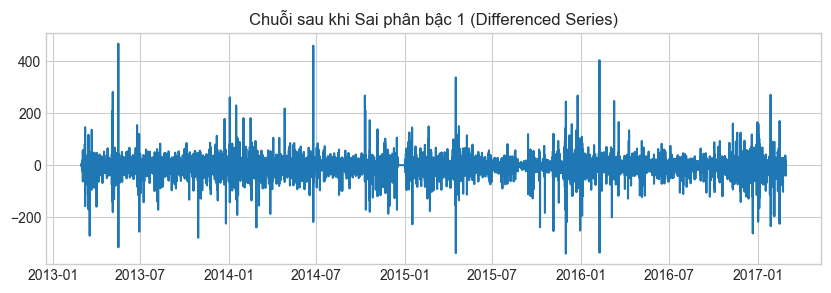

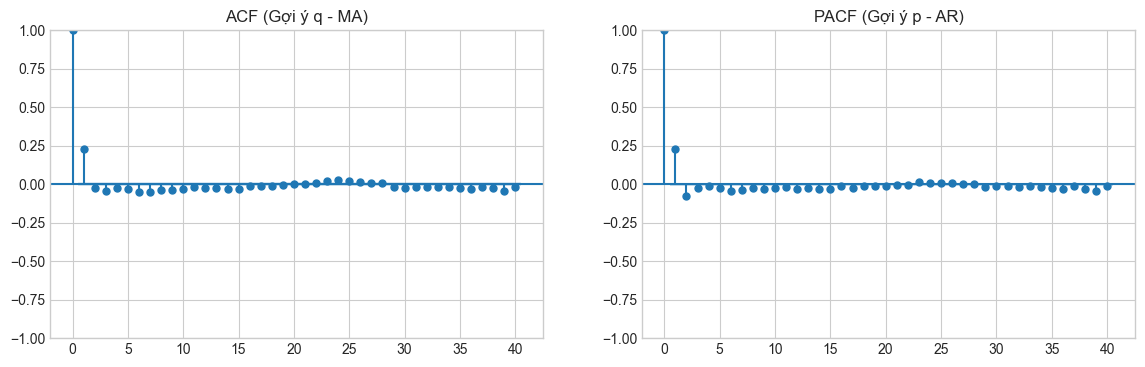

➤ Hướng dẫn đọc đồ thị:
   - Nếu PACF tắt (cut off) sau lag k -> Chọn p = k.
   - Nếu ACF tắt (cut off) sau lag j -> Chọn q = j.

--- QUY TRÌNH QUYẾT ĐỊNH ARIMA ---
1. Quan sát chuỗi gốc: Nhận diện xu hướng (Trend) và Mùa vụ (Seasonality).
2. Chọn d: Dựa vào kiểm định ADF. Nếu chưa dừng -> tăng d (thường d=0 hoặc d=1 với PM2.5).
3. Chọn Ứng viên (p, q): Dựa vào đồ thị ACF và PACF ở trên.
4. Grid Search: Chạy vòng lặp các bộ (p,d,q) lân cận, chọn bộ có AIC/BIC thấp nhất.
5. Chẩn đoán phần dư (Residuals):
   - Kiểm tra xem phần dư có phải là 'White Noise' (Nhiễu trắng) không?
   - Nếu phần dư còn tự tương quan (nhìn ACF của phần dư), nghĩa là mô hình còn bỏ sót thông tin -> cần chỉnh p, q hoặc thêm mùa vụ (SARIMA).


In [15]:
"""
CELL 9: [Q3] QUY TRÌNH RA QUYẾT ĐỊNH ARIMA
Mục đích: Thực hiện các bước chẩn đoán để chọn tham số (p,d,q) và kiểm tra mô hình.
"""

# BƯỚC 1: XÁC ĐỊNH d (Integration)
# Nếu ADF p-value > 0.05 ở Q1, ta cần d=1.
# Thử sai phân bậc 1 và vẽ lại
diff_series = df['PM2.5'].diff().dropna()

plt.figure(figsize=(10, 3))
plt.plot(diff_series)
plt.title('Chuỗi sau khi Sai phân bậc 1 (Differenced Series)')
plt.show()

# BƯỚC 2: XÁC ĐỊNH p, q (ACF & PACF)
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(diff_series, lags=40, ax=ax[0], title='ACF (Gợi ý q - MA)')
plot_pacf(diff_series, lags=40, ax=ax[1], title='PACF (Gợi ý p - AR)')
plt.show()
print("➤ Hướng dẫn đọc đồ thị:")
print("   - Nếu PACF tắt (cut off) sau lag k -> Chọn p = k.")
print("   - Nếu ACF tắt (cut off) sau lag j -> Chọn q = j.")

# BƯỚC 3: GIẢI THÍCH QUY TRÌNH (Markdown render bằng print)
print("\n--- QUY TRÌNH QUYẾT ĐỊNH ARIMA ---")
print("1. Quan sát chuỗi gốc: Nhận diện xu hướng (Trend) và Mùa vụ (Seasonality).")
print("2. Chọn d: Dựa vào kiểm định ADF. Nếu chưa dừng -> tăng d (thường d=0 hoặc d=1 với PM2.5).")
print("3. Chọn Ứng viên (p, q): Dựa vào đồ thị ACF và PACF ở trên.")
print("4. Grid Search: Chạy vòng lặp các bộ (p,d,q) lân cận, chọn bộ có AIC/BIC thấp nhất.")
print("5. Chẩn đoán phần dư (Residuals):")
print("   - Kiểm tra xem phần dư có phải là 'White Noise' (Nhiễu trắng) không?")
print("   - Nếu phần dư còn tự tương quan (nhìn ACF của phần dư), nghĩa là mô hình còn bỏ sót thông tin -> cần chỉnh p, q hoặc thêm mùa vụ (SARIMA).")